T3_PPO_LightSimBackend_MlpLstmPolicy_Batch32

In [1]:
# Import Libraries

import grid2op
from grid2op.Backend import PandaPowerBackend
from grid2op.Reward import L2RPNReward
from grid2op.Rules import DefaultRules
from grid2op.Action import TopologySetAction
from grid2op.Action import *
from grid2op.PlotGrid import PlotMatplot
from grid2op.Agent import BaseAgent
from grid2op.Runner import Runner
from grid2op.Episode import EpisodeData
from grid2op.gym_compat import BoxGymObsSpace, BoxGymActSpace, GymEnv
from gymnasium import Env
from lightsim2grid import LightSimBackend
from stable_baselines3 import SAC, PPO
from sb3_contrib import RecurrentPPO

import shutil
from tqdm.notebook import tqdm
import os
from collections import OrderedDict

2024-09-27 02:44:35.661024: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-27 02:44:35.693896: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-27 02:44:36.291586: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Create Environment

env_name_train = "/home/diogogoid/Tese/0.Implementation_V2/data_train"
env_name_test = "/home/diogogoid/Tese/0.Implementation_V2/data_test"

env_train = grid2op.make(env_name_train, backend=LightSimBackend(), reward_class=L2RPNReward, action_class=TopologySetAction, test=False)
env_test = grid2op.make(env_name_test, backend=LightSimBackend(), reward_class=L2RPNReward, action_class=TopologySetAction, test=False)

SEED=1

env_train.seed(SEED)
env_test.seed(SEED)

obs_train = env_train.reset()
obs_test = env_test.reset()

In [3]:
# Check dataset length

dataset_length = env_train.chronics_handler.max_timestep()
print(f"The length of the dataset train is: {dataset_length}")

dataset_length = env_test.chronics_handler.max_timestep()
print(f"The length of the dataset test is: {dataset_length}")

The length of the dataset train is: 2303
The length of the dataset test is: 671


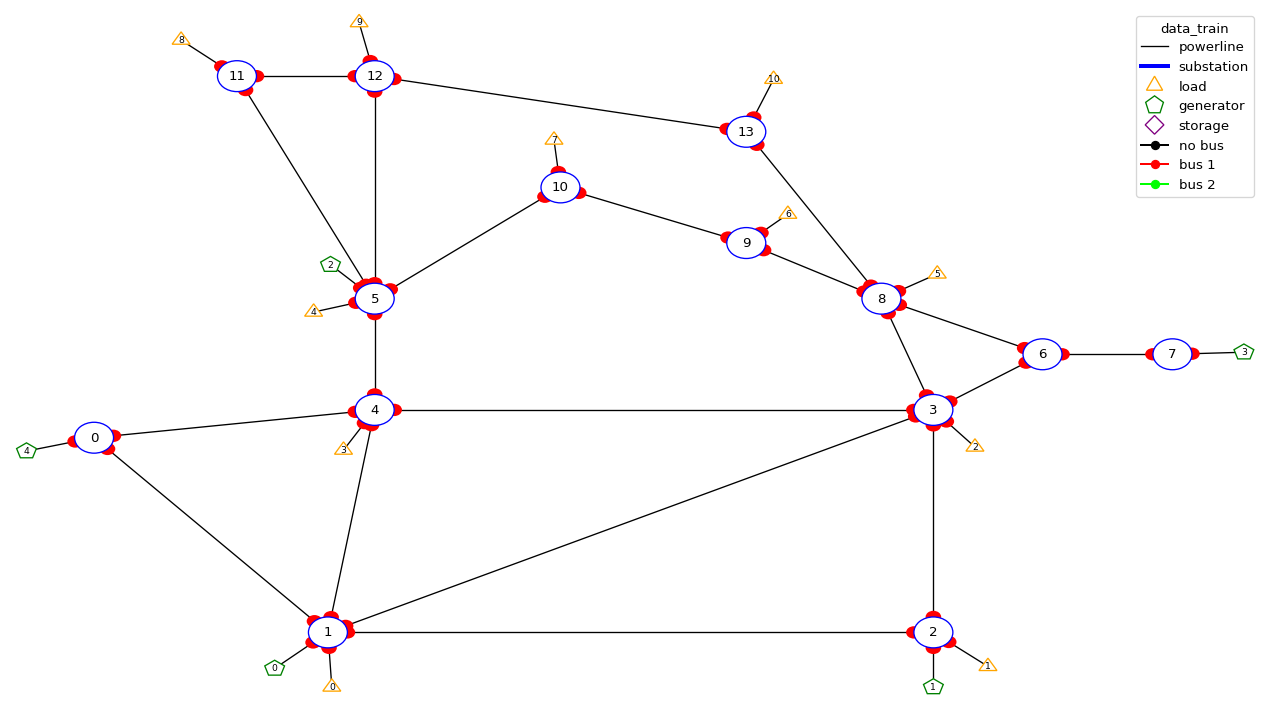

In [4]:
# Plot power grid

plot_helper = PlotMatplot(env_train.observation_space)
fig_info = plot_helper.plot_info()

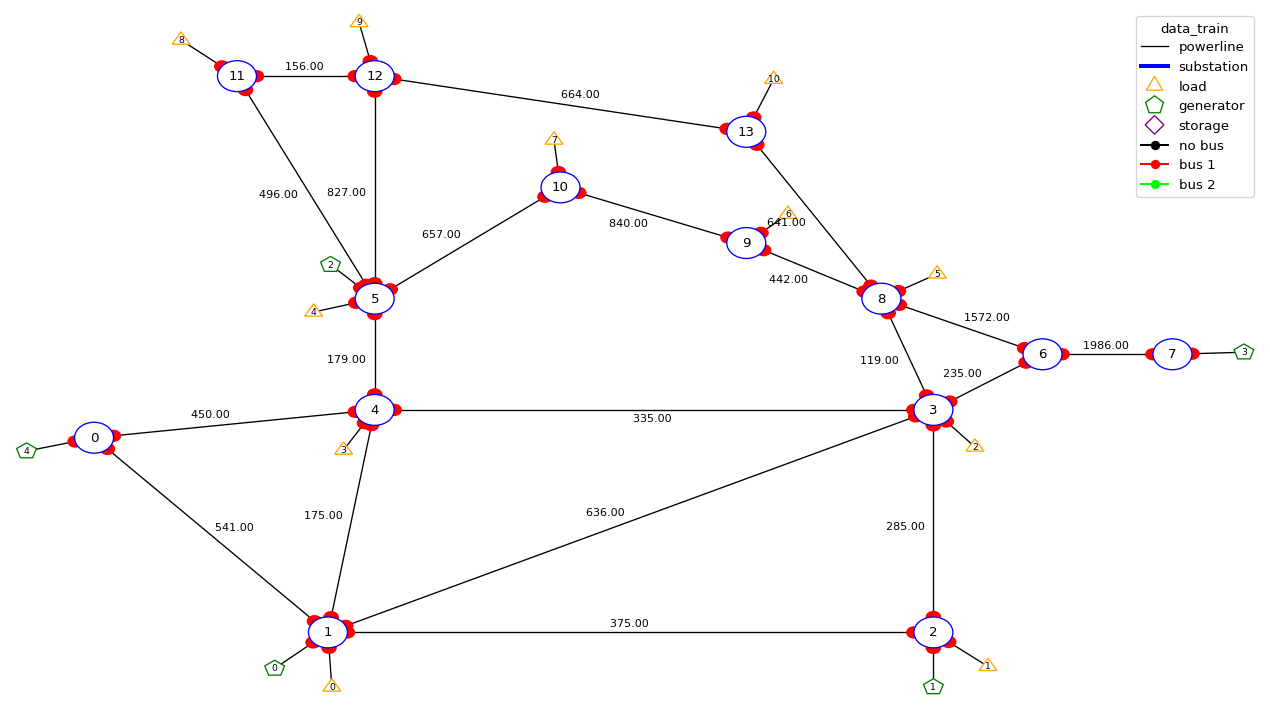

In [5]:
# Plot power grid with thermal limits in powerlines

fig_info = plot_helper.plot_info(line_values=env_train.get_thermal_limit())

In [6]:
# Create a gym compatible environment

env_gym_train = GymEnv(env_train)
isinstance(env_gym_train, Env)

True

In [7]:
env_gym_train.action_space

Dict('set_bus': Box(-1, 2, (56,), int32), 'set_line_status': Box(-1, 1, (20,), int32))

In [8]:
env_gym_train.observation_space

Dict('_shunt_bus': Box(-2147483648, 2147483647, (1,), int32), '_shunt_p': Box(-inf, inf, (1,), float32), '_shunt_q': Box(-inf, inf, (1,), float32), '_shunt_v': Box(-inf, inf, (1,), float32), 'a_ex': Box(0.0, inf, (20,), float32), 'a_or': Box(0.0, inf, (20,), float32), 'actual_dispatch': Box([-140. -120.  -70.  -40. -100.], [140. 120.  70.  40. 100.], (5,), float32), 'attention_budget': Box(0.0, inf, (1,), float32), 'current_step': Box(-2147483648, 2147483647, (1,), int32), 'curtailment': Box(0.0, 1.0, (5,), float32), 'curtailment_limit': Box(0.0, 1.0, (5,), float32), 'curtailment_limit_effective': Box(0.0, 1.0, (5,), float32), 'day': Discrete(32), 'day_of_week': Discrete(8), 'delta_time': Box(0.0, inf, (1,), float32), 'duration_next_maintenance': Box(-1, 2147483647, (20,), int32), 'gen_margin_down': Box(0.0, [ 0. 10.  0.  0. 10.], (5,), float32), 'gen_margin_up': Box(0.0, [ 0. 10.  0.  0. 10.], (5,), float32), 'gen_p': Box(-141.01, [281.01    261.01    211.01001 181.01    241.01001], (

In [9]:
# Customize observation and action space

obs_attr_to_keep = ["day_of_week", "hour_of_day", "minute_of_hour", "gen_p", "gen_q", "gen_v", "load_p", "load_q", "load_v",
                    "topo_vect", "time_before_cooldown_line", "time_before_cooldown_sub", "rho", "timestep_overflow", "line_status",
                    "p_or", "q_or", "v_or", "p_ex", "q_ex", "v_ex"]
act_attr_to_keep = ["set_line_status"]

In [10]:
# Define the action space and observation for train

env_gym_train.observation_space.close()
env_gym_train.observation_space = BoxGymObsSpace(env_train.observation_space,
                                           attr_to_keep=obs_attr_to_keep)
env_gym_train.action_space.close()
env_gym_train.action_space = BoxGymActSpace(env_train.action_space,
                                      attr_to_keep=act_attr_to_keep)

/home/diogogoid/.local/lib/python3.10/site-packages/grid2op/gym_compat/box_gym_actspace.py:238: UserWarning: The class "BoxGymActSpace" should mainly be used to consider only continuous actions (eg. redispatch, set_storage or curtail). Though it is possible to use "set_line_status" when building it, be aware that this discrete action will be treated as continuous. Consider using the "MultiDiscreteActSpace" for these attributes.
  warnings.warn(


In [11]:
# Define the action space and observation for test

env_gym_test = GymEnv(env_test)
env_gym_test.observation_space.close()
env_gym_test.observation_space = BoxGymObsSpace(env_test.observation_space,
                                           attr_to_keep=obs_attr_to_keep)
env_gym_test.action_space.close()
env_gym_test.action_space = BoxGymActSpace(env_test.action_space,
                                      attr_to_keep=act_attr_to_keep)

/home/diogogoid/.local/lib/python3.10/site-packages/grid2op/gym_compat/box_gym_actspace.py:238: UserWarning: The class "BoxGymActSpace" should mainly be used to consider only continuous actions (eg. redispatch, set_storage or curtail). Though it is possible to use "set_line_status" when building it, be aware that this discrete action will be treated as continuous. Consider using the "MultiDiscreteActSpace" for these attributes.
  warnings.warn(


In [12]:
# Model agent

nn_model = RecurrentPPO(env=env_gym_train,
                        learning_rate=1e-3,
                        policy="MlpLstmPolicy",
                        policy_kwargs={"net_arch": [200, 200, 200]},
                        batch_size=32,
                        seed=SEED,
                        verbose=False,)

In [13]:
LEARNING_ITERATION = 2303
EVAL_EPISODE = 1
MAX_EVAL_STEPS = 671

In [14]:
# Model agent learning

nn_model.learn(total_timesteps=LEARNING_ITERATION)

In [15]:
# Agent creation
class MyAgent(BaseAgent):
    def __init__(self, action_space, used_trained_gym_env, trained_agent, grid2op_env):
        super().__init__(action_space)
        self.nn_model = trained_agent
        self.gym_env = used_trained_gym_env  # Gym-based environment
        self.grid2op_env = grid2op_env  # The native Grid2Op environment
        self.line_to_keep_open = 17  # Line to open initially
        self.first_step = True  # Flag to track if this is the first step
        self.current_timestep = 0  # Manual timestep tracker

    # Apply the first reconnecting action if available, otherwise disconnect
    def apply_first_different_action(self, grid2op_act, obs):
        # Get the predicted line status changes
        line_status_changes = grid2op_act.set_line_status  

        # Reconnect actions will be favored
        reconnect_action = None
        disconnect_action = None

        # Iterate over each line and check if the status needs to change
        for line_id, status in enumerate(line_status_changes):
            current_status = obs.line_status[line_id]  # Get the current line status (True for connected, False for disconnected)
            desired_status = status == 1  # 1 means connected (reconnect), -1 means disconnected

            if current_status != desired_status:
                if desired_status:  # Favor reconnections (True -> reconnect)
                    print(f"Favoring reconnect action for line {line_id}: current status = {current_status}, predicted = {desired_status}")
                    reconnect_action = (line_id, status)
                    break  # Prioritize reconnect and apply it
                else:
                    print(f"Found disconnect action for line {line_id}: current status = {current_status}, predicted = {desired_status}")
                    if disconnect_action is None:  # Keep track of the first disconnect action
                        disconnect_action = (line_id, status)

        # Apply reconnect if found, else apply disconnect
        if reconnect_action:
            new_action = self.action_space()
            new_action.set_line_status = [reconnect_action]
            return new_action
        elif disconnect_action:
            new_action = self.action_space()
            new_action.set_line_status = [disconnect_action]
            return new_action

        # If no changes are necessary, return None
        print("No different action found.")
        return None

    def act(self, observation, reward, done=False):
        # Normal agent behavior after the first step
        gym_obs = self.gym_env.observation_space.to_gym(observation)

        # Get the action from the trained model
        gym_act, _ = self.nn_model.predict(gym_obs, deterministic=True)

        # Convert the action from gym format to grid2op format
        grid2op_act = self.gym_env.action_space.from_gym(gym_act)

        # Print the predicted action
        print(f"Timestep: {self.current_timestep}")
        print(f"Predicted gym action: {gym_act}")

        # Validate the action and apply only the first reconnect or different change
        print(f"Validating action at timestep {self.current_timestep}")
        valid_action = self.apply_first_different_action(grid2op_act, observation)

        if not valid_action:
            print("No action needed for this timestep.")
            return self.action_space()  # No action

        # Print out the action that will be taken
        print(f"Action to be taken (after validation): {valid_action}")

        # Simulate the action and check legality through the environment
        try:
            obs_before = observation
            obs_after, reward_tmp, done_tmp, info_tmp = self.grid2op_env.step(valid_action)

            # Check if the action was ambiguous or illegal after application
            if info_tmp.get("is_illegal", False):
                print("The action was marked illegal after application.")
            elif info_tmp.get("is_ambiguous", False):
                print("The action was ambiguous.")
            else:
                print("Action applied successfully.")
        except Exception as e:
            print(f"Exception during action application: {e}")

        self.current_timestep += 1
        return valid_action

    
my_agent = MyAgent(env_test.action_space, env_gym_train, nn_model,env_test)

In [16]:
# Testing and saving results

base_path = os.path.expanduser("~/Tese/0.Implementation_V2/implementation/T3_PPO_LightSimBackend_MlpLstmPolicy_Batch32")

save_path = os.path.join(base_path, 'T3_PPO_LightSimBackend_MlpLstmPolicy_Batch32')
path_save_results = "{}_results".format(save_path)
shutil.rmtree(path_save_results, ignore_errors=True)

test_runner = Runner(**env_test.get_params_for_runner(),
                     agentInstance=my_agent, agentClass=None)
res = test_runner.run(nb_episode=EVAL_EPISODE,
                      max_iter=MAX_EVAL_STEPS,
                      pbar=tqdm,
                      path_save=path_save_results)

episode:   0%|          | 0/1 [00:00<?, ?it/s]

episode:   0%|          | 0/671 [00:00<?, ?it/s]

Timestep: 0
Predicted gym action: [-0.09123503 -0.30008483  0.117147    0.53889209 -0.02040902 -0.35181358
 -0.29578018 -0.2413321  -0.01097318 -0.09178699 -0.28559205  0.08893576
  0.13309468  0.39821777 -0.16887632  0.12761323  0.2862269   0.01521608
 -0.57295835 -0.23461279]
Validating action at timestep 0
Found disconnect action for line 0: current status = True, predicted = False
Found disconnect action for line 1: current status = True, predicted = False
Found disconnect action for line 2: current status = True, predicted = False
Found disconnect action for line 4: current status = True, predicted = False
Found disconnect action for line 5: current status = True, predicted = False
Found disconnect action for line 6: current status = True, predicted = False
Found disconnect action for line 7: current status = True, predicted = False
Found disconnect action for line 8: current status = True, predicted = False
Found disconnect action for line 9: current status = True, predicted = Fa

In [17]:
# Results location

EpisodeData.list_episode(path_save_results)

[('/home/diogogoid/Tese/0.Implementation_V2/implementation/T3_PPO_LightSimBackend_MlpLstmPolicy_Batch32/T3_PPO_LightSimBackend_MlpLstmPolicy_Batch32_results',
  '0000')]

In [18]:
# Reward obtain

print("The results for the evaluated agent are:")
for _, chron_id, cum_reward, nb_time_step, max_ts in res:
    msg_tmp = "\tFor chronics with id {}\n".format(chron_id)
    msg_tmp += "\t\t - cumulative reward: {:.6f}\n".format(cum_reward)
    msg_tmp += "\t\t - number of time steps completed: {:.0f} / {:.0f}".format(nb_time_step, max_ts)
    print(msg_tmp)

The results for the evaluated agent are:
	For chronics with id 0000
		 - cumulative reward: 11948.493164
		 - number of time steps completed: 671 / 671


Inspect the actions

In [19]:
all_episodes = EpisodeData.list_episode(path_save_results)
this_episode = EpisodeData.from_disk(*all_episodes[0])
li_actions = this_episode.actions

In [20]:
# Lines reconnected and disconnected

line_disc = 0
line_reco = 0
for act in li_actions:
    dict_ = act.as_dict()
    if "set_line_status" in dict_:
        line_reco +=  dict_["set_line_status"]["nb_connected"]
        line_disc +=  dict_["set_line_status"]["nb_disconnected"]
print(f'Total reconnected lines : {line_reco}')
print(f'Total disconnected lines : {line_disc}')

Total reconnected lines : 0
Total disconnected lines : 0


In [21]:
# Print each unique action and its first occurrence timestep

unique_actions = OrderedDict()

for i, act in enumerate(li_actions):
    action_description = str(act)  # Get the string description of the action
    if action_description not in unique_actions:
        unique_actions[action_description] = i

print("The agent did {} different valid actions.".format(len(unique_actions)))

for action_description, timestep in unique_actions.items():
    print(f"Action first occurred at timestep {timestep}:")
    print(action_description)
    print("\n")

The agent did 1 different valid actions.
Action first occurred at timestep 0:
This action will:
	 - NOT change anything to the injections
	 - NOT perform any redispatching action
	 - NOT modify any storage capacity
	 - NOT perform any curtailment
	 - NOT force any line status
	 - NOT switch any line status
	 - NOT switch anything in the topology
	 - NOT force any particular bus configuration


